In [8]:
import random
import docplex.mp as mp
from docplex.mp.model import Model
import sys
from datetime import datetime
import threading
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
print(sys.version)

3.7.3 (default, Apr 24 2019, 15:29:51) [MSC v.1915 64 bit (AMD64)]


In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Sets and Parameters

## Model Class

In [10]:
 class FirstStage:
        
        def __init__(self,cost,add_I_Cost,initialI,Cost0):
            self.m = Model(name = "FirstStage")
            self.c= cost
            self.I1 = initialI
            self.add_I_C = add_I_Cost
            self.C0 = Cost0
                
        def createVariables(self):
#             self.x = self.m.continuous_var_dict(keys=dictat, name="X") #Unloaded chasis moves
#             self.y = self.m.continuous_var_dict(keys=dictl_le_at, name="Y") #L,E 
            self.I = self.m.continuous_var_dict(keys=dictl_ec_a1, name="I") #E,C /end of period acctng
#             self.add_I1 = self.m.continuous_var_dict(keys= dictl_ec_at, name = "add_I")
            self.theta = self.m.continuous_var(lb=-1e+19,ub=1e+19, name = "theta")
            self.xy0 = self.m.continuous_var_dict(keys = dictl_ec_a, name = "XY0")
            self.add_I = self.m.continuous_var_dict(keys = dictla, name = "add_I")
           
        def createObjective(self):
            self.m.minimize(self.m.sum(self.C0[j][i]*self.xy0[j,i] for j in ("E", "C") for i in A)+self.m.sum(self.add_I_C[l][a]*self.add_I[l,a] for l in Load for a in A)+self.theta)
        
        def createConstraints(self):
            self.ct_I1 = {}
            self.ct_xBound = {}
            self.ct_yBound ={}
            self.ocut = {}
            self.ocut_count = 1
            self.fcut = {}
            self.fcut_count = 1
            
            for i in A:
                for j in Load:
                    if j == 'C':
                        self.ct_I1[j,i] = self.m.add_constraint(self.I[j,i,1] == self.m.sum(self.xy0[j2,i] for j2 in Load if j2 != 'L') - self.m.sum(self.xy0[j2,i2] for j2 in Load if j2 != 'L' for i2 in A if i2 != i) + self.I1[j][i] + self.add_I[j,i])
                        self.ct_xBound[i] = self.m.add_constraint(self.xy0['C',i] + self.xy0['E',i] - self.m.sum(self.I1['E'][i2] + self.add_I['E',i2] for i2 in A if i2 != i)<= 0) 
                        #self.ct_I1[j,i] = self.m.add_constraint(self.I1[j][i] >= self.I[j,i,1])
                    if j == 'E':
                        self.ct_I1[j,i] = self.m.add_constraint(self.I[j,i,1] == self.xy0[j,i] - self.m.sum(self.xy0[j,i2] for i2 in A if i2 != i) + self.I1[j][i] + self.add_I[j,i])
                        self.ct_yBound[i] = self.m.add_constraint(self.xy0['E',i] - self.m.sum(self.I1['E'][i2] + self.add_I['E',i2] for i2 in A if i2 != i) <=0)

            
        def addOptimalityCut(self, e, E):
            self.ocut[self.ocut_count] = self.m.add_constraint(self.m.sum(E[i]*i for i in self.m.iter_continuous_vars() if i.name != "theta" and "XY0" not in i.name and "add_I" not in i.name) + self.theta >= e, ctname = "OCut "+str(self.ocut_count))
            self.ocut_count = self.ocut_count + 1
            
        def addFeasibilityCut(self, d, D):
            self.ocut[self.ocut_count] = self.m.add_constraint(self.m.sum(D[i.name]*i for i in self.m.iter_continuous_vars() if i.name != "theta" and "XY0" not in i.name and "add_I" not in i.name) >= d, ctname = "FCut "+str(self.fcut_count))
            self.fcut_count = self.fcut_count + 1
            
        def solveModel(self):
            self.m.solve()
            #print(self.m.report)
            #print("solve status =",self.m.get_solve_status()) 
            #print(self.m.solution)
            
            
        def exportModel(self):
            self.m.export_as_lp("C:/Users/ccpur/Documents/IMSE867/firstStageStochastic.lp")
               

In [11]:
 class SecondStage:
        
        def __init__(self, scenarioIndex, Dem, Cost):
            self.opt_runtime = datetime.now()
            #print("")
            #print("Second Stage Starts: ", scenarioIndex )
            self.m = Model(name = "SecondStage, %s" %(scenarioIndex))
            self.scenarioIndex = scenarioIndex
            self.d = Dem #Surplus ommitted. Modeled by negative Demand.
            self.c = Cost
            self.v_dict = {}
            for i in A:
                for k in T:
                    self.v_dict["Demand", "L",i,k] = ""
                    self.v_dict["Demand", "E", i ,k] = ""
            for k in T:
                if k != sizeT:
                    self.v_dict["Inv", "C", "a1" , k] = ""
            for k in T:
                if k != sizeT:
                    self.v_dict["Inv", "C", "a2", k] = ""
            for k in T:
                if k != sizeT:
                    self.v_dict["Inv", "E", "a1",k] = ""
            for k in T:
                if k != sizeT:
                    self.v_dict["Inv","E", "a2",k] = ""
            for k in T:
                self.v_dict["B<C","a1",k] = ""
            for k in T:
                self.v_dict["B<C","a2",k] = ""
            self.vpn_dict = [(i, p) for i in self.v_dict.keys() for p in ["pos","neg"]]
                

        def createVariables(self):
            self.x = self.m.continuous_var_dict(keys=dictat, name="X") #Unloaded chasis moves
            self.y = self.m.continuous_var_dict(keys=dictl_le_at, name="Y") #L,E 
            self.I = self.m.continuous_var_dict(keys=dictl_ec_at, name="I") #E,C /end of period acctng
            
        def createObjective(self):
            self.m.minimize(self.m.sum(self.c[j][i][k]*self.y[j,i,k] for j in Load if j != 'C' for i in A for k in T)+self.m.sum(self.c['C'][a][k]*self.x[a,k] for a in A for k in T))
        
        def assigndvars(self, stage1):
            
            self.Itemp = stage1.m.solution.get_value_dict(stage1.I)
            
            self.ct_Importer = {}

            for i in A:
                for j in Load:
                    if j != "L":
                        name = "Importer, %s, %s" %(j, i)
                        self.ct_Importer[j,i] = self.m.add_constraint(self.I[j,i,1] == self.Itemp[j,i,1], ctname = name)

        
        def createConstraints(self, stage1):
            
            self.ct_Demand= {}
            self.ct_Inv= {}
            self.ct_BoxesLEChassis= {}
            self.ct_I_continuity = {}

            for i in A:
                for k in T:
                    name = "Demand, L, %s, %s" %(i, k)
                    self.ct_Demand['L', i,k] = self.m.add_constraint(self.d['L'][i][k] <= self.y['L',i,k], ctname = name)  
                    name = "Demand, E, %s, %s" %(i, k)
                    self.ct_Demand['E', i,k] = self.m.add_constraint(self.d['E'][i][k]<=self.y['E',i,k]+self.I['E',i,k], ctname = name)
            for k in T:
                if k != sizeT:
                    name = "Inv, C, a1, %s" %(k)
                    self.ct_Inv['C','a1',k] = self.m.add_constraint(self.I['C','a1',k+1] == self.I['C','a1',k]+self.x['a1',k]-self.x['a2',k]+self.y['L','a1',k]-self.y['L','a2',k]+self.y['E','a1',k]-self.y['E','a2',k], ctname=name)
            for k in T:
                if k != sizeT:
                    name = "Inv, C, a2, %s" %(k)
                    self.ct_Inv['C','a2',k] = self.m.add_constraint(self.I['C','a2',k+1] == self.I['C','a2',k]+self.x['a2',k]-self.x['a1',k]+self.y['L','a2',k]-self.y['L','a1',k]+self.y['E','a2',k]-self.y['E','a1',k], ctname = name)
            for k in T:
                if k != sizeT:
                    name = "Inv, E, a1, %s" %(k)
                    self.ct_Inv['E','a1',k] = self.m.add_constraint(self.I['E','a1',k+1]==self.I['E','a1',k]+self.y['E','a1',k]-self.y['E','a2',k]-self.d['E']['a1'][k], ctname = name)
            for k in T:
                if k != sizeT:
                    name = "Inv, E, a2, %s" %(k)
                    self.ct_Inv['E','a2',k] = self.m.add_constraint(self.I['E','a2',k+1]==self.I['E','a2',k]+self.y['E','a2',k]-self.y['E','a1',k]-self.d['E']['a2'][k], ctname=name)
            for k in T:
                name = "B<C, a1, %s" %(k)
                self.ct_BoxesLEChassis['a1',k] = self.m.add_constraint(self.I['C','a2',k]+self.x['a2',k]>=self.m.sum(self.y[j,'a1',k]-self.y[j,'a2',k] for j in Load if j != 'C'),ctname=name)
            for k in T:
                name = "B<C, a2, %s" %(k)
                self.ct_BoxesLEChassis['a2',k] = self.m.add_constraint(self.I['C','a1',k]+self.x['a1',k]>=self.m.sum(self.y[j,'a2',k]-self.y[j,'a1',k] for j in Load if j != 'C'),ctname = name)
#             for j in Load:
#                 for k in T:
#                     if k != sizeT and j != "L" and j!="E":
#                         self.ct_I_continuity[j,k] = self.m.add_constraint(self.I[j,"a1",k]+self.I[j,"a2",k] == self.I[j,"a1",k+1]+self.I[j,"a2",k+1])
            self.assigndvars(stage1)
            
        def calculateOptimalityCutValues(self, stage1):
            
            ConstNames = {"Demand, L": ["A, T"], "Demand, E": ["A, T"], "Inv, C, a1": ["T"], "Inv, C, a2": ["T"],"Inv, E, a1": ["T"], "Inv, E, a2": ["T"], "B<C, a1": ["T"], "B<C, a2": ["T"] }
            FirstStageVars = ['I_L_a1_1', 'I_E_a1_1', 'I_C_a1_1', 'I_L_a2_1', 'I_E_a2_1', 'I_C_a2_1']
            #                     0           1           2           3           4         5
            self.EOpt = {}
            self.eOpt = 0
            for var in FirstStageVars:
                self.EOpt[var] = 0
            
            for const in self.m.iter_constraints():
                constname = str(const.name)
                split = constname.split(", ")
#                 print(const, "\t", const.dual_value)
                if constname is not None:
                    #Demand E, i, 1
                    if list(ConstNames.keys())[0] in constname:
                            self.eOpt = self.eOpt + const.dual_value*1*self.d['L']['a%s' %(split[-2][-1])][int(split[-1])] #pos 1 because CPLEX moves constants over to LHS in preprocessin
#                             if const.dual_value*1*self.d['L']['a%s' %(split[-2][-1])][int(split[-1])] != 0:
#                                 print("Dual = ", const.dual_value, " h = ",1*self.d['L']['a%s' %(split[-2][-1])][int(split[-1])] ," constraint name = ", constname)
                    elif list(ConstNames.keys())[1] in constname:
                            if split[-2][-1] == "1": #at a1
                                if split[-1] == "1":
                                    self.EOpt[FirstStageVars[1]] = self.EOpt[FirstStageVars[1]] + const.dual_value*-1
                                    self.eOpt = self.eOpt + const.dual_value*1*self.d['E']['a1'][1]
#                                     if const.dual_value*1*self.d['E']['a1'][1] != 0:
#                                         print("Dual = ", const.dual_value, " h = ",1*self.d['E']['a1'][1] ," constraint name = ", constname)
                                else:
                                    self.eOpt = self.eOpt + const.dual_value*1*self.d['E']['a1'][int(split[-1])]
#                                     if const.dual_value*1*self.d['E']['a1'][int(split[-1])] != 0:
#                                         print("Dual = ", const.dual_value, " h = ",1*self.d['E']['a1'][int(split[-1])] ," constraint name = ", constname)
                                        
                            if split[-2][-1] == "2": #at a2
                                if split[-1] == "1":
                                    self.EOpt[FirstStageVars[4]] = self.EOpt[FirstStageVars[4]] + const.dual_value*-1
                                    self.eOpt = self.eOpt + const.dual_value*1*self.d['E']['a2'][1]
#                                     if const.dual_value*1*self.d['E']['a2'][1] != 0:
#                                         print("Dual = ", const.dual_value, " h = ", 1*self.d['E']['a2'][1]," constraint name = ", constname)
                                else:
                                    self.eOpt = self.eOpt + const.dual_value*1*self.d['E']['a2'][int(split[-1])]
#                                     if const.dual_value*1*self.d['E']['a2'][int(split[-1])] != 0:
#                                         print("Dual = ", const.dual_value, " h = ",1*self.d['E']['a2'][int(split[-1])] ," constraint name = ", constname)

                    elif list(ConstNames.keys())[2] in constname and split[-1] == "1":
                        self.EOpt[FirstStageVars[2]] = self.EOpt[FirstStageVars[2]] + const.dual_value*-1
#                         if const.dual_value*1 != 0:
#                             print(const, "\t", const.dual_value)
#                             print(FirstStageVars[2], " += ",const.dual_value*-1)

                    elif list(ConstNames.keys())[3] in constname and split[-1] == "1":
                        self.EOpt[FirstStageVars[5]] = self.EOpt[FirstStageVars[5]] + const.dual_value*-1
#                         if const.dual_value*1 != 0:
#                             print(const, "\t", const.dual_value)
#                             print(FirstStageVars[5], " += ",const.dual_value*-1)

                    elif list(ConstNames.keys())[4] in constname:
                        if split[-1] == "1":
                            self.EOpt[FirstStageVars[1]] = self.EOpt[FirstStageVars[1]] + const.dual_value*-1
                            self.eOpt = self.eOpt + const.dual_value*-1*self.d['E']['a1'][1]
#                             if const.dual_value*-1*self.d['E']['a1'][1] != 0:
#                                         print("Dual = ", const.dual_value, " h = ",-1*self.d['E']['a1'][1] ," constraint name = ", constname)
                        else:
                            self.eOpt = self.eOpt + const.dual_value*-1*self.d['E']['a1'][int(split[-1])]
#                             if const.dual_value*-1*self.d['E']['a1'][int(split[-1])] != 0:
#                                         print("Dual = ", const.dual_value, " h = ",-1*self.d['E']['a1'][int(split[-1])] ," constraint name = ", constname)

                    elif list(ConstNames.keys())[5] in constname:
                        if split[-1] == "1":
                            self.EOpt[FirstStageVars[4]] = self.EOpt[FirstStageVars[4]] + const.dual_value*-1
                            self.eOpt = self.eOpt + const.dual_value*-1*self.d['E']['a2'][1]
#                             if const.dual_value*-1*self.d['E']['a2'][1] != 0:
#                                         print("Dual = ", const.dual_value, " h = ",-1*self.d['E']['a2'][1] ," constraint name = ", constname)
                        else:
                            self.eOpt = self.eOpt + const.dual_value*-1*self.d['E']['a2'][int(split[-1])]
#                             if const.dual_value*-1*self.d['E']['a2'][int(split[-1])] != 0:
#                                         print("Dual = ", const.dual_value, " h = ", -1*self.d['E']['a2'][int(split[-1])]," constraint name = ", constname)

                    elif list(ConstNames.keys())[6] in constname and split[-1] == "1":
                        self.EOpt[FirstStageVars[5]] = self.EOpt[FirstStageVars[5]] + const.dual_value*1
#                         if const.dual_value*1 != 0:
#                             print(const, "\t", const.dual_value)
#                             print(FirstStageVars[5], " += ",const.dual_value*1)

                    elif list(ConstNames.keys())[7] in constname and split[-1] == "1":
                        self.EOpt[FirstStageVars[2]] = self.EOpt[FirstStageVars[2]] + const.dual_value*1
#                         if const.dual_value*1 != 0:
#                             print(const, "\t", const.dual_value)
#                             print(FirstStageVars[2], " += ",const.dual_value*1)
            
           
        def calculateFeasilityCutValues(self, stage1):
            self.feas_runtime = datetime.now()
            self.feasibilitySolutionFoundFlag = 0
            self.m = Model(name = "FeasibilityModel")
            pn = ["pos","neg"]
            
            self.x = self.m.continuous_var_dict(keys=dictat, name="X") #Unloaded chasis moves
            self.y = self.m.continuous_var_dict(keys=dictl_le_at, name="Y") #L,E 
            self.I = self.m.continuous_var_dict(keys=dictl_ec_at, name="I") #E,C /end of period acctng
            self.v = self.m.continuous_var_dict(keys = self.vpn_dict, name = "V" ) #pos and neg "slack" variables for each constraint in stage1
        
        
            self.m.minimize(self.m.sum(self.v[vpn]*1 for vpn in self.vpn_dict))
        
        
            self.ct_Demand= {}
            self.ct_Inv= {}
            self.ct_BoxesLEChassis= {}

            for i in A:
                for k in T:
                    name = "Demand, L, %s, %s" %(i, k)
                    self.ct_Demand['L', i,k] = self.m.add_constraint(self.d['L'][i][k] - self.v[(("Demand","L",i,k),"neg")] <= self.y['L',i,k],ctname = name)  
                    name = "Demand, E, %s, %s" %(i, k)
                    self.ct_Demand['E', i,k] = self.m.add_constraint(self.d['E'][i][k] - self.v[(("Demand","E",i,k),"neg")] <= self.y['E',i,k]+self.I['E',i,k], ctname = name)
            for k in T:
                if k != sizeT:
                    name = "Inv, C, a1, %s" %(k)
                    self.ct_Inv['C','a1',k] = self.m.add_constraint(self.I['C','a1',k+1] + self.v[(("Inv","C","a1",k),"pos")] - self.v[(("Inv","C","a1",k),"neg")]== self.I['C','a1',k]+self.x['a1',k]-self.x['a2',k]+self.y['L','a1',k]-self.y['L','a2',k]+self.y['E','a1',k]-self.y['E','a2',k], ctname = name)
            for k in T:
                if k != sizeT:
                    name = "Inv, C, a2, %s" %(k)
                    self.ct_Inv['C','a2',k] = self.m.add_constraint(self.I['C','a2',k+1] + self.v[(("Inv","C","a2",k),"pos")] - self.v[(("Inv","C","a2",k),"neg")]== self.I['C','a2',k]+self.x['a2',k]-self.x['a1',k]+self.y['L','a2',k]-self.y['L','a1',k]+self.y['E','a2',k]-self.y['E','a1',k], ctname = name)
            for k in T:
                if k != sizeT:
                    name = "Inv, E, a1, %s" %(k)
                    self.ct_Inv['E','a1',k] = self.m.add_constraint(self.I['E','a1',k+1] + self.v[(("Inv","E","a1",k),"pos")] - self.v[(("Inv","E","a1",k),"neg")] ==self.I['E','a1',k]+self.y['E','a1',k]-self.y['E','a2',k]-self.d['E']['a1'][k], ctname = name)
            for k in T:
                if k != sizeT:
                    name = "Inv, E, a2, %s" %(k)
                    self.ct_Inv['E','a2',k] = self.m.add_constraint(self.I['E','a2',k+1] + self.v[(("Inv","E","a2",k),"pos")] - self.v[(("Inv","E","a2",k),"neg")] ==self.I['E','a2',k]+self.y['E','a2',k]-self.y['E','a1',k]-self.d['E']['a2'][k], ctname = name)
            for k in T:
                name = "B<C, a1, %s" %(k)
                self.ct_BoxesLEChassis['a1',k] = self.m.add_constraint(self.I['C','a2',k]+self.x['a2',k] + self.v[(("B<C","a1",k),"pos")]>= self.m.sum(self.y[j,'a1',k]-self.y[j,'a2',k] for j in Load if j != 'C'), ctname = name)
            for k in T:
                name = "B<C, a2, %s" %(k)
                self.ct_BoxesLEChassis['a2',k] = self.m.add_constraint(self.I['C','a1',k]+self.x['a1',k] + self.v[(("B<C","a2",k),"pos")]>=self.m.sum(self.y[j,'a2',k]-self.y[j,'a1',k] for j in Load if j != 'C'), ctname = name)

            self.assigndvars(stage1)
           
            self.m.solve()
            if(self.m.objective_value > 0):
                
                self.feasibilitySolutionFoundFlag = 1
                #print(self.m.solution)
                ConstNames = {"Demand, L": ["A, T"], "Demand, E": ["A, T"], "Inv, C, a1": ["T"], "Inv, C, a2": ["T"],"Inv, E, a1": ["T"], "Inv, E, a2": ["T"], "B<C, a1": ["T"], "B<C, a2": ["T"] }
                FirstStageVars = ['I_L_a1_1', 'I_E_a1_1', 'I_C_a1_1', 'I_L_a2_1', 'I_E_a2_1', 'I_C_a2_1']
                
                self.DOpt = {}
                self.dOpt = 0
                for var in FirstStageVars:
                    self.DOpt[var] = 0

                for const in self.m.iter_constraints():
                    constname = str(const.name)
                    split = constname.split(", ")
                    if constname is not None:
                        #Demand E, i, 1
                        if list(ConstNames.keys())[0] in constname:
                            self.dOpt = self.dOpt + const.dual_value*1*self.d['L']['a%s' %(split[-2][-1])][int(split[-1])] #pos 1 because CPLEX moves constants over to LHS in preprocessing
                        elif list(ConstNames.keys())[1] in constname:
                                if split[-2][-1] == "1": #at a1
                                    if split[-1] == "1":
                                        self.DOpt[FirstStageVars[1]] = self.DOpt[FirstStageVars[1]] + const.dual_value*-1
                                        self.dOpt = self.dOpt + const.dual_value*1*self.d['E']['a1'][1]
                                    else:
                                        self.dOpt = self.dOpt + const.dual_value*1*self.d['E']['a1'][int(split[-1])]
                                if split[-2][-1] == "2": #at a2
                                    if split[-1] == "1":
                                        self.DOpt[FirstStageVars[4]] = self.DOpt[FirstStageVars[4]] + const.dual_value*-1
                                        self.dOpt = self.dOpt + const.dual_value*1*self.d['E']['a2'][1]
                                    else:
                                        self.dOpt = self.dOpt + const.dual_value*1*self.d['E']['a2'][int(split[-1])]

                        elif list(ConstNames.keys())[2] in constname and split[-1] == "1":
                            self.DOpt[FirstStageVars[2]] = self.DOpt[FirstStageVars[2]] + const.dual_value*-1

                        elif list(ConstNames.keys())[3] in constname and split[-1] == "1":
                            self.DOpt[FirstStageVars[5]] = self.DOpt[FirstStageVars[5]] + const.dual_value*-1

                        elif list(ConstNames.keys())[4] in constname:
                            if split[-1] == "1":
                                self.DOpt[FirstStageVars[1]] = self.DOpt[FirstStageVars[1]] + const.dual_value*-1
                                self.dOpt = self.dOpt + const.dual_value*-1*self.d['E']['a1'][1]
                            else:
                                self.dOpt = self.dOpt + const.dual_value*-1*self.d['E']['a1'][int(split[-1])]
                            
                        elif list(ConstNames.keys())[5] in constname:
                            if split[-1] == "1":
                                self.DOpt[FirstStageVars[4]] = self.DOpt[FirstStageVars[4]] + const.dual_value*-1
                                self.dOpt = self.dOpt + const.dual_value*-1*self.d['E']['a2'][1]
                            else:
                                self.dOpt = self.dOpt + const.dual_value*-1*self.d['E']['a2'][int(split[-1])]
                                
                        elif list(ConstNames.keys())[6] in constname and split[-1] == "1":
                            self.DOpt[FirstStageVars[5]] = self.DOpt[FirstStageVars[5]] + const.dual_value*1

                        elif list(ConstNames.keys())[7] in constname and split[-1] == "1":
                            self.DOpt[FirstStageVars[2]] = self.DOpt[FirstStageVars[2]] + const.dual_value*1
                self.feas_runtime = (datetime.now()-self.feas_runtime).total_seconds()
    
        def solveModel(self):
            self.m.solve()
            self.opt_runtime = (datetime.now()-self.opt_runtime).total_seconds()
            #print(self.m.report)
            #print("solve status =",self.m.get_solve_status()) 
            #print(self.m.solution)
                
        def solution(self): 
            print("Second Stage Starts: ", self.scenarioIndex )
            print(self.m.solution)
            
        def exportModel(self):
            self.m.export_as_lp("C:/Users/ashes/Documents/IMSE867/secondStageStochastic.lp")
               

##  Thread Runners

In [12]:
def OptCreateSolve(j,D,C,firstStage1):
            secondStage[j] = SecondStage(j, D,C)
            secondStage[j].createVariables()
            secondStage[j].createObjective()
            secondStage[j].createConstraints(firstStage1)
            secondStage[j].solveModel()

## Extensive Form Model Class

In [13]:
class deterministic:
    def run(self,name2, Dem, Cost, initialI, add_I_Cost, Cost0, scenarios, probabilities):
        self.m = Model(name = name2)
        self.d = Dem #Surplus ommitted. Modeled by negative Demand.
        self.c = Cost
        self.I1 = initialI
        self.add_I_C = add_I_Cost
        self.Scenarios = scenarios
        self.probs = probabilities
        self.C0 = Cost0
        
            #dvars

        self.x = self.m.continuous_var_dict(keys=dictsat, name="X") #Unloaded chassis moves
        self.y = self.m.continuous_var_dict(keys=dictsl_le_at, name="Y") #L,E 
        self.I = self.m.continuous_var_dict(keys=dictsl_ec_at, name="I") #E,C /end of period acctng
        self.xy0 = self.m.continuous_var_dict(keys = dictl_ec_a, name = "XY0")
        self.add_I = self.m.continuous_var_dict(keys = dictla, name = "addI")

            #Obj Function
        #Full
        self.m.minimize(self.m.sum(self.probs[s]*self.c[s][j][i][k]*self.y[s,j,i,k] for s in self.Scenarios for j in Load if j != 'C' for i in A for k in T)+self.m.sum(self.xy0[j,i] for j in ("E", "C") for i in A)+self.m.sum(self.probs[s]*self.c[s]['C'][a][k]*self.x[s,a,k] for s in self.Scenarios for a in A for k in T)+self.m.sum(self.add_I_C[l][a]*self.add_I[l,a] for l in Load for a in A))
        #1st Stage
        #self.m.minimize(self.m.sum(self.xy0[j,i] for j in ("E", "C") for i in A))
        #2nd Stage
        #self.m.minimize(self.m.sum(self.c[j][i][k]*self.y[j,i,k] for j in Load if j != 'C' for i in A for k in T))

        self.ct_Demand= {}
        self.ct_Inv= {}
        self.ct_BoxesLEChassis= {}
        self.ct_I_continuity = {}
        self.ct_I1 = {}
        self.ct_xBound = {}
        self.ct_yBound ={}

        for s in self.Scenarios:
            for i in A:
                for k in T:
                    name = "Demand, L, %s, %s, %s" %(i, k, s)
                    self.ct_Demand['L', i,k] = self.m.add_constraint(self.d[s]['L'][i][k] <= self.y[s,'L',i,k], ctname = name)  
                    name = "Demand, E, %s, %s" %(i, k)
                    self.ct_Demand['E', i,k] = self.m.add_constraint(self.d[s]['E'][i][k]<=self.y[s,'E',i,k]+self.I[s,'E',i,k], ctname = name)
            for k in T:
                if k != sizeT:
                    name = "Inv, C, a1, %s, %s" %(k, s)
                    self.ct_Inv[s,'C','a1',k] = self.m.add_constraint(self.I[s,'C','a1',k+1] == self.I[s,'C','a1',k]+self.x[s,'a1',k]-self.x[s,'a2',k]+self.y[s,'L','a1',k]-self.y[s,'L','a2',k]+self.y[s,'E','a1',k]-self.y[s,'E','a2',k], ctname=name)
            for k in T:
                if k != sizeT:
                    name = "Inv, C, a2, %s, %s" %(k, s)
                    self.ct_Inv[s,'C','a2',k] = self.m.add_constraint(self.I[s,'C','a2',k+1] == self.I[s,'C','a2',k]+self.x[s,'a2',k]-self.x[s,'a1',k]+self.y[s,'L','a2',k]-self.y[s,'L','a1',k]+self.y[s,'E','a2',k]-self.y[s,'E','a1',k], ctname = name)
            for k in T:
                if k != sizeT:
                    name = "Inv, E, a1, %s, %s" %(k, s)
                    self.ct_Inv[s,'E','a1',k] = self.m.add_constraint(self.I[s,'E','a1',k+1]==self.I[s,'E','a1',k]+self.y[s,'E','a1',k]-self.y[s,'E','a2',k]-self.d[s]['E']['a1'][k], ctname = name)
            for k in T:
                if k != sizeT:
                    name = "Inv, E, a2, %s, %s" %(k, s)
                    self.ct_Inv[s,'E','a2',k] = self.m.add_constraint(self.I[s,'E','a2',k+1]==self.I[s,'E','a2',k]+self.y[s,'E','a2',k]-self.y[s,'E','a1',k]-self.d[s]['E']['a2'][k], ctname=name)
            for k in T:
                name = "B<C, a1, %s, %s" %(k, s)
                self.ct_BoxesLEChassis[s,'a1',k] = self.m.add_constraint(self.I[s,'C','a2',k]+self.x[s,'a2',k]>=self.m.sum(self.y[s,j,'a1',k]-self.y[s,j,'a2',k] for j in Load if j != 'C'),ctname=name)
            for k in T:
                name = "B<C, a2, %s, %s" %(k, s)
                self.ct_BoxesLEChassis[s,'a2',k] = self.m.add_constraint(self.I[s,'C','a1',k]+self.x[s,'a1',k]>=self.m.sum(self.y[s,j,'a2',k]-self.y[s,j,'a1',k] for j in Load if j != 'C'),ctname = name)
            for j in Load:
                for k in T:
                    if k != sizeT and j != "L" and j!="E":
                        self.ct_I_continuity[s,j,k] = self.m.add_constraint(self.I[s,j,"a1",k]+self.I[s,j,"a2",k] == self.I[s,j,"a1",k+1]+self.I[s,j,"a2",k+1])
            for i in A:
                for j in Load:
                    if j == 'C':
                        self.ct_I1[s,j,i] = self.m.add_constraint(self.I[s,j,i,1] == self.m.sum(self.xy0[j2,i] for j2 in Load if j2 != 'L') - self.m.sum(self.xy0[j2,i2] for j2 in Load if j2 != 'L' for i2 in A if i2 != i) + self.I1[j][i] + self.add_I[j,i])
                        self.ct_xBound[i] = self.m.add_constraint(self.xy0['C',i] + self.xy0['E',i] - self.m.sum(self.I1['E'][i2] + self.add_I['E',i2] for i2 in A if i2 != i)<= 0) 
                        #self.ct_I1[j,i] = self.m.add_constraint(self.I1[j][i] >= self.I[j,i,1])
                    if j == 'E':
                        self.ct_I1[s,j,i] = self.m.add_constraint(self.I[s,j,i,1] == self.xy0[j,i] - self.m.sum(self.xy0[j,i2] for i2 in A if i2 != i) + self.I1[j][i] + self.add_I[j,i])
                        self.ct_yBound[i] = self.m.add_constraint(self.xy0['E',i] - self.m.sum(self.I1['E'][i2] + self.add_I['E',i2] for i2 in A if i2 != i) <=0)
        self.m.solve()
#         print(self.m.solution)

## L Shaped Method Run Model

In [18]:
random.seed(10)
#Sets
TimeRange = []

for i in range(10,105,5): TimeRange.append(i)
runcollectorT = {}
    
for sizeT in TimeRange:
    print("Time Size: " , sizeT)
    Load =('L','E','C')
    A = ('a1','a2')
    T=[1]
    iT=1
    Scenarios = []
    for i in range(1,21): Scenarios.append(i)
    Probabilities = {}
    for s in Scenarios:
        Probabilities[s] = 1/len(Scenarios)

    while iT < sizeT:
        T.append(iT+1)
        iT = iT+1

    dictat = [(a,t) for a in A for t in T]
    dictla = [(l,a) for l in Load for a in A]
    dictl_le_at = [(l,a,t) for l in Load if l != 'C' for a in A for t in T]
    dictl_ec_at = [(l,a,t) for l in Load if l != 'L'for a in A for t in T]
    dictl_ec_a1 = [(l,a,t) for l in Load if l != 'L'for a in A for t in [1]]
    dictlat = [(l,a,t) for l in Load for a in A for t in T]
    dictl_ec_a = [(l,a) for a in A for l in Load if l != 'L']
    dictsat = [(s,a,t) for s in Scenarios for a in A for t in T]
    dictsl_le_at = [(s,l,a,t) for s in Scenarios for l in Load if l != 'C' for a in A for t in T]
    dictsl_ec_at = [(s,l,a,t) for s in Scenarios for l in Load if l != 'L'for a in A for t in T]


    D = {}
    C = {}
    I1 = {}
    add_I_C = {}

    for level in Scenarios:
        D[level]={}
        for l in Load:
            D[level][l]={}
            for a in A:
                D[level][l][a]={}
                for t in T:
                    D[level][l][a][t]={}
                    #print(l, a, t)
                    if l == "E":
                        D[level][l][a][t] = max(round(random.normalvariate(2,1)),0)
                    if l == "L":
                        D[level][l][a][t] = max(round(random.normalvariate(50,15)),0)
    #                 if a == 'a1' and t == 1:
    #                     D[level][l][a][t] = 0 
    #                 elif a == 'a2' and t == 2 and l == "L":
    #                     D[level][l][a][t] = 3
    # #                 else:
    # #                     D[level][l][a][t] = 0
    # print(D)
        add_I_C[level] = {}
        for l in Load:
            add_I_C[level][l] = {}
            for a in A:
                add_I_C[level][l][a] = max(round(random.normalvariate(1000,100)),0)

    for level in Scenarios:
        C[level]={}
        for l in Load:
            C[level][l]={}
            for a in A:
                C[level][l][a]={}
                for t in T:
                    C[level][l][a][t]={}
                    C[level][l][a][t] = max(round(random.normalvariate(100,10)),0)

    for l in Load:
        I1[l]={}
        for a in A:
            I1[l][a]= 0#random.randint(1,2)
    #         if a == "a2":
    #             I1[l][a]= 3
    # #         I1[l][a]= 6
    # #         if a == 'a1':
    # #             I1[l][a]= 0
    C0={}
    for l in Load:
        C0[l] = {}
        for a in A:
            C0[l][a] = 1

    ConstNames = {"Demand, L": ["A, T"], "Demand, E": ["A, T"], "Inv, C, a1": ["T"], "Inv, C, a2": ["T"],"Inv, E, a1": ["T"], "Inv, E, a2": ["T"], "B<C, a1": ["T"], "B<C, a2": ["T"] }
    FirstStageVars = []
    for i in A:
        for j in Load:
            FirstStageVars.append("I_"+j+"_"+i+"_1")

    batches = {}
    threadmax = 10000
    tspair = []
    j = 1
    batchi = 1
    batches[batchi] = []
    for i in Scenarios:
        batches[batchi].append((i,j))
        if j == threadmax:
            j=1
            batchi+=1
            batches[batchi] = []
        else:
            j+=1

    # Run first stage model
    firstStage = FirstStage(C[1],add_I_C[1],I1,C0)
    #firstStage = FirstStage(C[1],add_I_C[1],I1,[0,0])
    firstStage.createVariables()
    firstStage.createObjective()
    firstStage.createConstraints()
    firstStage.solveModel()

    optimalFlag = 0
    itercount = 0
    starttime = datetime.now()

    firstStageOld = firstStage
    revruntime = {}
    # ------------------------------------------------------------------------------------
    # ------------------------------------------------------------------------------------
    # L Shaped Algorithm

    while optimalFlag == 0:
        #print("---------------------------------------------------------------------------")
        #print("")
        #print("Iterations: ", iter)
        itercount = itercount + 1
        revruntime[itercount] = 0

#         print("\n\nIteration: ", itercount)
        firstStage1 = firstStageOld
        modelFeasible = True
        # Run second stage for each scenario
        secondStage = {}
        E = []
        infeasibles = []
        for batch in batches.keys():
            threads = {}
            for j, thread in batches[batch]:
                threads[thread] = threading.Thread(target = OptCreateSolve(j,D[j],C[j],firstStage1))
                threads[thread].start()

            for thread in threads:
                threads[thread].join()
        revruntime[itercount]+=max(secondStage[j].opt_runtime for j in Scenarios)

        for batch in batches.keys():
            threads = {}
            for j, thread in batches[batch]:
                if secondStage[j].m.solution== None:
        #             print(j)
                    modelFeasible = False
                    threads[thread] = threading.Thread(target = secondStage[j].calculateFeasilityCutValues(firstStage1))
                    threads[thread].start()
                    infeasibles.append(j)
            for thread in threads:
                threads[thread].join()

        if modelFeasible == False:
            revruntime[itercount]+=max(secondStage[j].feas_runtime for j in infeasibles)

            for j in infeasibles:
                firstStage1.addFeasibilityCut(secondStage[j].dOpt, secondStage[j].DOpt)
        #             print("Added cut of dOpt = ", secondStage[j].dOpt, "and DOpt = ",secondStage[j].DOpt)
        cut_runtime = datetime.now()    
#         print("Model Feasible? ",modelFeasible)
        if modelFeasible == False:
            # Run first stage with feasibility cut
            firtStageOld = firstStage1
            #firstStage1.exportModel()
            firstStage1.solveModel()
            #print(firstStage1.m.solution)
        else:
            # Aggregate Scenarios for Optimality Cut

            E = {}
            e = 0

            for j in Scenarios:
    #             print(j,"\n")
                secondStage[j].calculateOptimalityCutValues(firstStage)
                e = e + Probabilities[s]*secondStage[j].eOpt
                for variable in firstStage1.m.iter_continuous_vars():
                    if variable.name != "theta" and "XY0" not in variable.name and "add_I" not in variable.name:
                        if variable not in E.keys():
                            E[variable] = 0
                        E[variable] = E[variable] + Probabilities[s]*secondStage[j].EOpt[variable.name]
    #             print(secondStage[j].eOpt)
    #         print("Adding O-Cut w/ E = ", E, "\nAnd e = ", e)

            # Stopping Condition
            w = e - sum(E[variable]*firstStage.m.solution.get_value(variable) for variable in firstStage1.m.iter_continuous_vars() if variable.name != "theta" and "XY0" not in variable.name and "add_I" not in variable.name)

#             print("Stopping Condition\nStop if ",firstStage.m.solution.get_value(firstStage.theta) - w, " >= 0")
            if firstStage.m.solution.get_value(firstStage.theta) + 1e-8 < w:
                #print(e,E)
                firstStage1.addOptimalityCut(e, E)
                firtStageOld = firstStage1
                #firstStage1.exportModel()
                firstStage1.solveModel()
                cut_runtime= (datetime.now()-cut_runtime).total_seconds()
                revruntime[itercount]+= cut_runtime

                #print("")
                #print("Optimality Cut: ", E, e)
                #print("Obj: " , firstStage1.m.solution.objective_value, " ", w)
                #print(firstStage1.m.solution.get_value_dict(firstStage1.x))
                #print("Theta: " , firstStage1.m.solution.get_value(firstStage1.theta))
            else:
                optimalFlag = 1
                print("-------------------------------------------------------------")
                print("Optimal Soluion")
                #firstStage1.exportModel()
                firstStage1.solveModel()
                cut_runtime= (cut_runtime-datetime.now()).total_seconds()
                revruntime[itercount]+= cut_runtime
    #             for j in Scenarios:
    #                 secondStage[j].solution()
                print(firstStage1.m.solution)
                print("Iterations = ",itercount)
                print("Runtime = ", (datetime.now()-starttime).total_seconds(), "sec.")
                print("Revised Runtime = ", sum(revruntime[i] for i in range(1,itercount)), "sec.\n")
                runcollectorT[sizeT] = sum(revruntime[i] for i in range(1,itercount))

Time Size:  10
-------------------------------------------------------------
Optimal Soluion
solution for: FirstStage
objective: 156584
I_E_a1_1=3.000
I_E_a2_1=39.000
theta=119585.150
XY0_E_a1=1.500
XY0_C_a2=1.500
add_I_E_a1=1.500
add_I_E_a2=40.500

Iterations =  7
Runtime =  3.148988 sec.
Revised Runtime =  0.8202 sec.

Time Size:  15
-------------------------------------------------------------
Optimal Soluion
solution for: FirstStage
objective: 243933
I_E_a1_1=49.000
I_E_a2_1=17.000
theta=174820.050
XY0_C_a1=8.500
XY0_E_a2=8.500
add_I_E_a1=57.500
add_I_E_a2=8.500

Iterations =  11
Runtime =  6.610263 sec.
Revised Runtime =  2.260825 sec.

Time Size:  20
-------------------------------------------------------------
Optimal Soluion
solution for: FirstStage
objective: 306726
I_E_a1_1=76.000
I_E_a2_1=9.000
theta=231062.475
XY0_C_a1=4.500
XY0_E_a2=4.500
add_I_E_a1=80.500
add_I_E_a2=4.500

Iterations =  9
Runtime =  7.740437 sec.
Revised Runtime =  2.7959340000000004 sec.

Time Size:  25


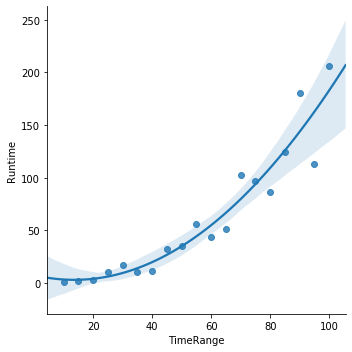

In [21]:
runtimesT = pd.DataFrame.from_dict(runcollectorT, 'index', columns = ['Runtime'])
runtimesT = runtimesT.reset_index().rename(columns = {'index': 'TimeRange'})

plot = sns.lmplot('TimeRange','Runtime' , runtimesT, order = 2)
plot.fig.savefig("TimeRange_Time.png")

In [22]:
runtimesT.to_csv('TimeRangeRuntimes.csv')